In [1]:
import xarray as xr
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from data_processor import DataProcessor
from regressor import Regressor

In [2]:
ds = xr.open_dataset("../data.grib")
t2m_numpy = ds.t2m.to_numpy() - 273.15  # -> C
sp_numpy = ds.sp.to_numpy() / 100       # -> hPa

data = np.stack((t2m_numpy, sp_numpy), axis=-1)
feature_list = [ds.t2m.name, ds.sp.name]

AUTOREG_SEQUENCE_LENGTH = 3
processor = DataProcessor(data)
X, y = processor.preprocess(AUTOREG_SEQUENCE_LENGTH)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [3]:
X.shape, X_train.shape, y_train.shape

((1078, 2, 25, 45, 2), (862, 2, 25, 45, 2), (862, 25, 45, 2))

In [4]:
data_shape = X.shape
linearreg = Regressor(data_shape, feature_list)
linearreg.train(X_train, y_train)

RMSE t2m: 1.253; R2 t2m: 0.768
RMSE sp: 1.187; R2 sp: 0.996


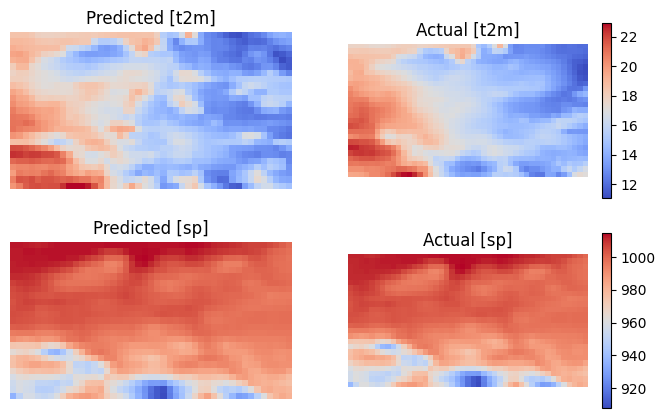

RMSE t2m: 1.146; R2 t2m: 0.779
RMSE sp: 1.181; R2 sp: 0.996


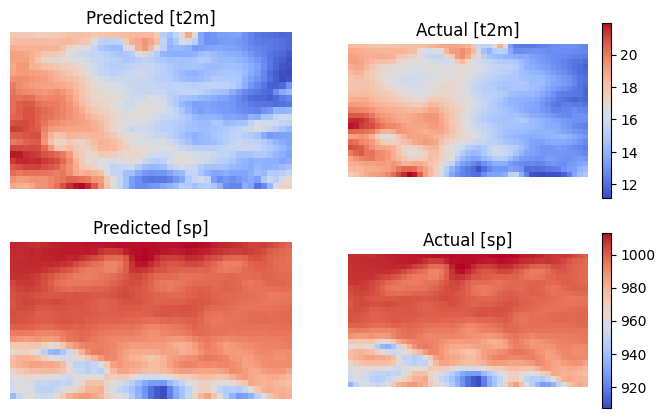

RMSE t2m: 7.233; R2 t2m: -13.888
RMSE sp: 0.864; R2 sp: 0.998


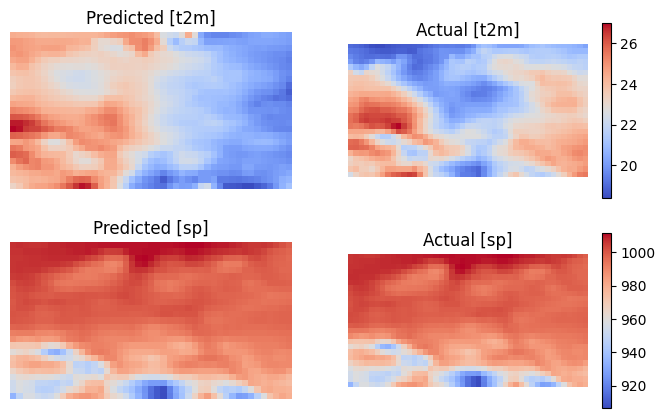

RMSE t2m: 3.356; R2 t2m: -0.836
RMSE sp: 0.537; R2 sp: 0.999


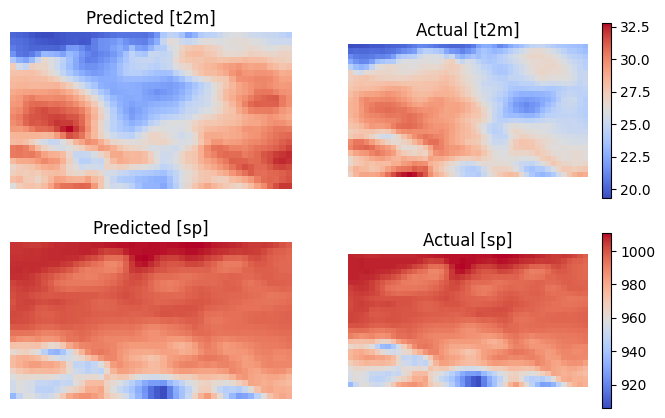

In [5]:
_ = linearreg.predict_and_evaluate(X_test, y_test, limit=4)